In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from pypots.data import load_specific_dataset
from pygrinder import mcar, masked_fill
from pypots.imputation import ImputeFormer
from pypots.utils.metrics import calc_mae, calc_mse, calc_rmse, calc_mre
from time import time
import sys
sys.path.append(".")
from model.Net import INet
import logging
from pypots.utils.logging import logger
import torch
import warnings
from typing import Union, Optional, Iterable
from pypots.data.dataset import BaseDataset
from torch.utils.data import DataLoader
from pypots.imputation.imputeformer.data import DatasetForImputeFormer
from pypots.data.checking import key_in_data_set
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
filename = "./logfiles/net.log"
logging.basicConfig(filename=filename, format='%(asctime)s %(filename)s %(levelname)s %(message)s',
                    datefmt='%a %d %b %Y %H:%M:%S', filemode='w', level=logging.INFO)
X = pd.read_csv('./datasets/caisson1.csv', index_col='collect_time', parse_dates=['collect_time'])
cols = X.shape[1]

TimeIndex = X.index
scalar = StandardScaler()
X = scalar.fit_transform(X.to_numpy())
window = 48
step = 48
X = np.array([X[i:i+window].tolist() for i in range(0,X.shape[0]-window + 1,step)] ,  dtype=np.float64)

original_shape = X.shape
X = X.flatten()
X_intact = np.copy(X)  # keep a copy of originally observed values in X_intact
# select random indices for artificial mask
indices = np.where(~np.isnan(X))[0].tolist()  # get the indices of observed values
indices = np.random.choice(indices, int(len(indices) * 0.2), replace=False)

# create artificially-missing values by selected indices
X[indices] = np.nan  
indicating_mask = ((~np.isnan(X_intact)) ^ (~np.isnan(X))).astype(np.float32)
missing_mask = (~np.isnan(X)).astype(np.float32)
X_intact = np.nan_to_num(X_intact)
X = np.nan_to_num(X)
X_intact = X_intact.reshape(original_shape)
X = X.reshape(original_shape)
missing_mask = missing_mask.reshape(original_shape)
indicating_mask = indicating_mask.reshape(original_shape)

all_len = X_intact.shape[0]
inds = np.random.permutation(all_len)
train_len = int(all_len * 0.6)
val_len = int(all_len * 0.2)
test_len = all_len - (train_len + val_len)

train_inds = inds[:train_len + val_len]
# val_inds = inds[train_len:-test_len]
test_inds = inds[-test_len:]
X = masked_fill(X, 1 - missing_mask, np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Training

In [2]:
net = INet(n_steps=window, n_features=cols, n_layers=2, d_input_embed = 24, d_learnable_embed = 80, d_proj = 10, d_ffn=128, dropout=0.1, n_temporal_heads=4, temporal_attention_mask=True)
net = net.to(device)
opt = torch.optim.Adam(net.parameters(), lr=0.001)
num_params = sum( p.numel() for p in net.parameters() if p.requires_grad)
logger.info(
    f"Net initialized with the given hyperparameters, "
    f"the number of trainable parameters: {num_params:,}"
)
train_set = {"X": X_intact[train_inds]}
val_set = None
batch_size = 32
training_set = DatasetForImputeFormer(train_set, return_X_ori=False, return_y=False)
training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = None
if val_set is not None:
    if not key_in_data_set("X_ori", val_set):
        raise ValueError("val_set must contain 'X_ori' for model validation.")
    val_set = DatasetForImputeFormer(val_set, return_X_ori=True, return_y=False)
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

def send_data_to_given_device(data) -> Iterable:
        if isinstance(device, torch.device):  # single device
            data = map(lambda x: x.to(device), data)
        else:  # parallely training on multiple devices
            # randomly choose one device to balance the workload
            # device = np.random.choice(self.device)

            data = map(lambda x: x.cuda(), data)

        return data
def assemble_input_for_training(data: list) -> dict:
        (
            indices,
            X,
            missing_mask,
            X_ori,
            indicating_mask,
        ) = send_data_to_given_device(data)

        inputs = {
            "X": X,
            "missing_mask": missing_mask,
            "X_ori": X_ori,
            "indicating_mask": indicating_mask,
        }

        return inputs
def assemble_input_for_validating(data: list) -> dict:
        return assemble_input_for_training(data)

def assemble_input_for_testing(data: list) -> dict:
    indices, X, missing_mask = send_data_to_given_device(data)

    inputs = {
        "X": X,
        "missing_mask": missing_mask,
    }

    return inputs

best_loss = float("inf")
best_model_dict = None
original_patience = None
t0 = time()
training_step = 0
epochs = 100
for epoch in range(1, epochs + 1):
    net.train()
    epoch_train_loss_collector = []
    for idx, data in enumerate(training_loader):
        training_step += 1
        inputs = assemble_input_for_training(data)
        opt.zero_grad()
        results = net.forward(inputs,temporal_attention_mask=True)
        # use sum() before backward() in case of multi-gpu training
        results["loss"].sum().backward()
        opt.step()
        epoch_train_loss_collector.append(results["loss"].sum().item())

        # save training loss logs into the tensorboard file for every step if in need
        # if self.summary_writer is not None:
        #     self._save_log_into_tb_file(training_step, "training", results)

    # mean training loss of the current epoch
    mean_train_loss = np.mean(epoch_train_loss_collector)

    if val_loader is not None:
        net.eval()
        imputation_loss_collector = []
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                inputs = assemble_input_for_validating(data)
                results = net.forward(inputs, training=False, temporal_attention_mask=True)
                imputation_mse = (
                    calc_mse(
                        results["imputed_data"],
                        inputs["X_ori"],
                        inputs["indicating_mask"],
                    )
                    .sum()
                    .detach()
                    .item()
                )
                imputation_loss_collector.append(imputation_mse)

        mean_val_loss = np.mean(imputation_loss_collector)

        # save validation loss logs into the tensorboard file for every epoch if in need
        # if self.summary_writer is not None:
        #     val_loss_dict = {
        #         "imputation_loss": mean_val_loss,
        #     }
        #     self._save_log_into_tb_file(epoch, "validating", val_loss_dict)

        logging.info(
            f"Epoch {epoch:03d} - "
            f"training loss: {mean_train_loss:.4f}, "
            f"validation loss: {mean_val_loss:.4f}"
        )
        mean_loss = mean_val_loss
    else:
        logger.info(f"Epoch {epoch:03d} - training loss: {mean_train_loss:.4f}")
        mean_loss = mean_train_loss

    if np.isnan(mean_loss):
        logger.warning(f"‼️ Attention: got NaN loss in Epoch {epoch}. This may lead to unexpected errors.")

    if mean_loss < best_loss:
        best_epoch = epoch
        best_loss = mean_loss
        best_model_dict = net.state_dict()
        torch.save(best_model_dict, './IModel.pt')
    #     patience = original_patience
    # else:
    #     patience -= 1

    # save the model if necessary
    # self._auto_save_model_if_necessary(
    #     confirm_saving=self.best_epoch == epoch and self.model_saving_strategy == "better",
    #     saving_name=f"{self.__class__.__name__}_epoch{epoch}_loss{mean_loss:.4f}",
    # )

    # if os.getenv("enable_tuning", False):
    #     nni.report_intermediate_result(mean_loss)
    #     if epoch == self.epochs - 1 or self.patience == 0:
    #         nni.report_final_result(self.best_loss)

    # if patience == 0:
    #     logging.info("Exceeded the training patience. Terminating the training procedure...")
    #     break
if best_model_dict is None:  # if no best model, raise error
    logger.error("Training got interrupted. Model was not trained. Please investigate the error printed above.")
            
if np.isnan(best_loss):
    logger.error("Something is wrong. best_loss is Nan after training.")

logger.info(f"Finished training. The best model is from epoch#{best_epoch}.")

2025-01-13 17:40:19 [INFO]: Net initialized with the given hyperparameters, the number of trainable parameters: 402,505
2025-01-13 17:41:08 [INFO]: Epoch 001 - training loss: 0.2295
2025-01-13 17:41:50 [INFO]: Epoch 002 - training loss: 0.1550
2025-01-13 17:42:32 [INFO]: Epoch 003 - training loss: 0.1414
2025-01-13 17:43:14 [INFO]: Epoch 004 - training loss: 0.1326
2025-01-13 17:43:57 [INFO]: Epoch 005 - training loss: 0.1254
2025-01-13 17:44:39 [INFO]: Epoch 006 - training loss: 0.1205
2025-01-13 17:45:21 [INFO]: Epoch 007 - training loss: 0.1121
2025-01-13 17:46:03 [INFO]: Epoch 008 - training loss: 0.1054
2025-01-13 17:46:45 [INFO]: Epoch 009 - training loss: 0.1005
2025-01-13 17:47:27 [INFO]: Epoch 010 - training loss: 0.0971
2025-01-13 17:48:09 [INFO]: Epoch 011 - training loss: 0.0955
2025-01-13 17:48:51 [INFO]: Epoch 012 - training loss: 0.0929
2025-01-13 17:49:33 [INFO]: Epoch 013 - training loss: 0.0928
2025-01-13 17:50:16 [INFO]: Epoch 014 - training loss: 0.0915
2025-01-13 1

# Model Testing

In [3]:
test_set = {"X": X[test_inds]}
net.load_state_dict(best_model_dict)
net.eval()  # set the model as eval status to freeze it.
# self.model.eval()  # set the model as eval status to freeze it.
test_set = BaseDataset(
    test_set,
    return_X_ori=False,
    return_X_pred=False,
    return_y=False
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)
imputation_collector = []

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        inputs = assemble_input_for_testing(data)
        results = net.forward(inputs, training=False, temporal_attention_mask= True)
        imputed_data = results["imputed_data"]
        imputation_collector.append(imputed_data)

imputation = torch.cat(imputation_collector).cpu().detach().numpy()

mae = calc_mae(imputation, X_intact[test_inds], indicating_mask[test_inds])  # calculate mean absolute error on the ground truth (artificially-missing values)
rmse = calc_rmse(imputation, X_intact[test_inds], indicating_mask[test_inds])
mre = calc_mre(imputation, X_intact[test_inds], indicating_mask[test_inds])
# r2 = r2_score(X_intact[indicating_mask], imputation[indicating_mask])
t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print('artificial imputation MAE: %.4f'%mae)
print('artificial imputation RMSE: %.4f'%rmse)
print('artificial imputation MRE: %.4f'%mre)
# ImputeFormer
# phase1
# artificial imputation MAE: 0.0244
# artificial imputation RMSE: 0.0935
# artificial imputation MRE: 0.0310
# phase2
# artificial imputation MAE: 0.0249
# artificial imputation RMSE: 0.0702
# artificial imputation MRE: 0.0310
# phase3
# artificial imputation MAE: 0.0303
# artificial imputation RMSE: 0.0554
# artificial imputation MRE: 0.0380

# w spatio_attn_mask
# artificial imputation MAE: 0.0335
# artificial imputation RMSE: 0.1364
# artificial imputation MRE: 0.0426

# projecAttn -> multiheadAttn
# phase1
# artificial imputation MAE: 0.0184
# artificial imputation RMSE: 0.0989
# artificial imputation MRE: 0.0233
# phase2
# artificial imputation MAE: 0.0214
# artificial imputation RMSE: 0.0709
# artificial imputation MRE: 0.0264
# phase3
# artificial imputation MAE: 0.0155
# artificial imputation RMSE: 0.0696
# artificial imputation MRE: 0.0199

Time taken to train the model: 3691.45 seconds
artificial imputation MAE: 0.3413
artificial imputation RMSE: 0.6528
artificial imputation MRE: 0.4839


# Moving average algorithm

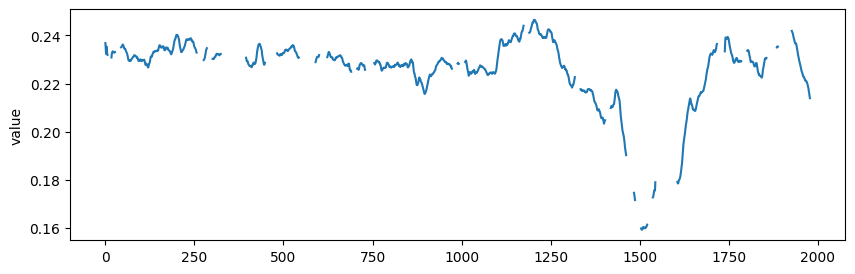

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
o = pd.read_csv('../../Datasets/MDatasets/phase1/targets.csv', index_col='collect_time', parse_dates=['collect_time'])
o = o.values
X = np.arange(2000)
plt.figure(figsize=(10, 3))
plt.ylabel('value')
plt.plot(X, o[:2000, -1])
plt.show()

# Impact of slide window and loss weight

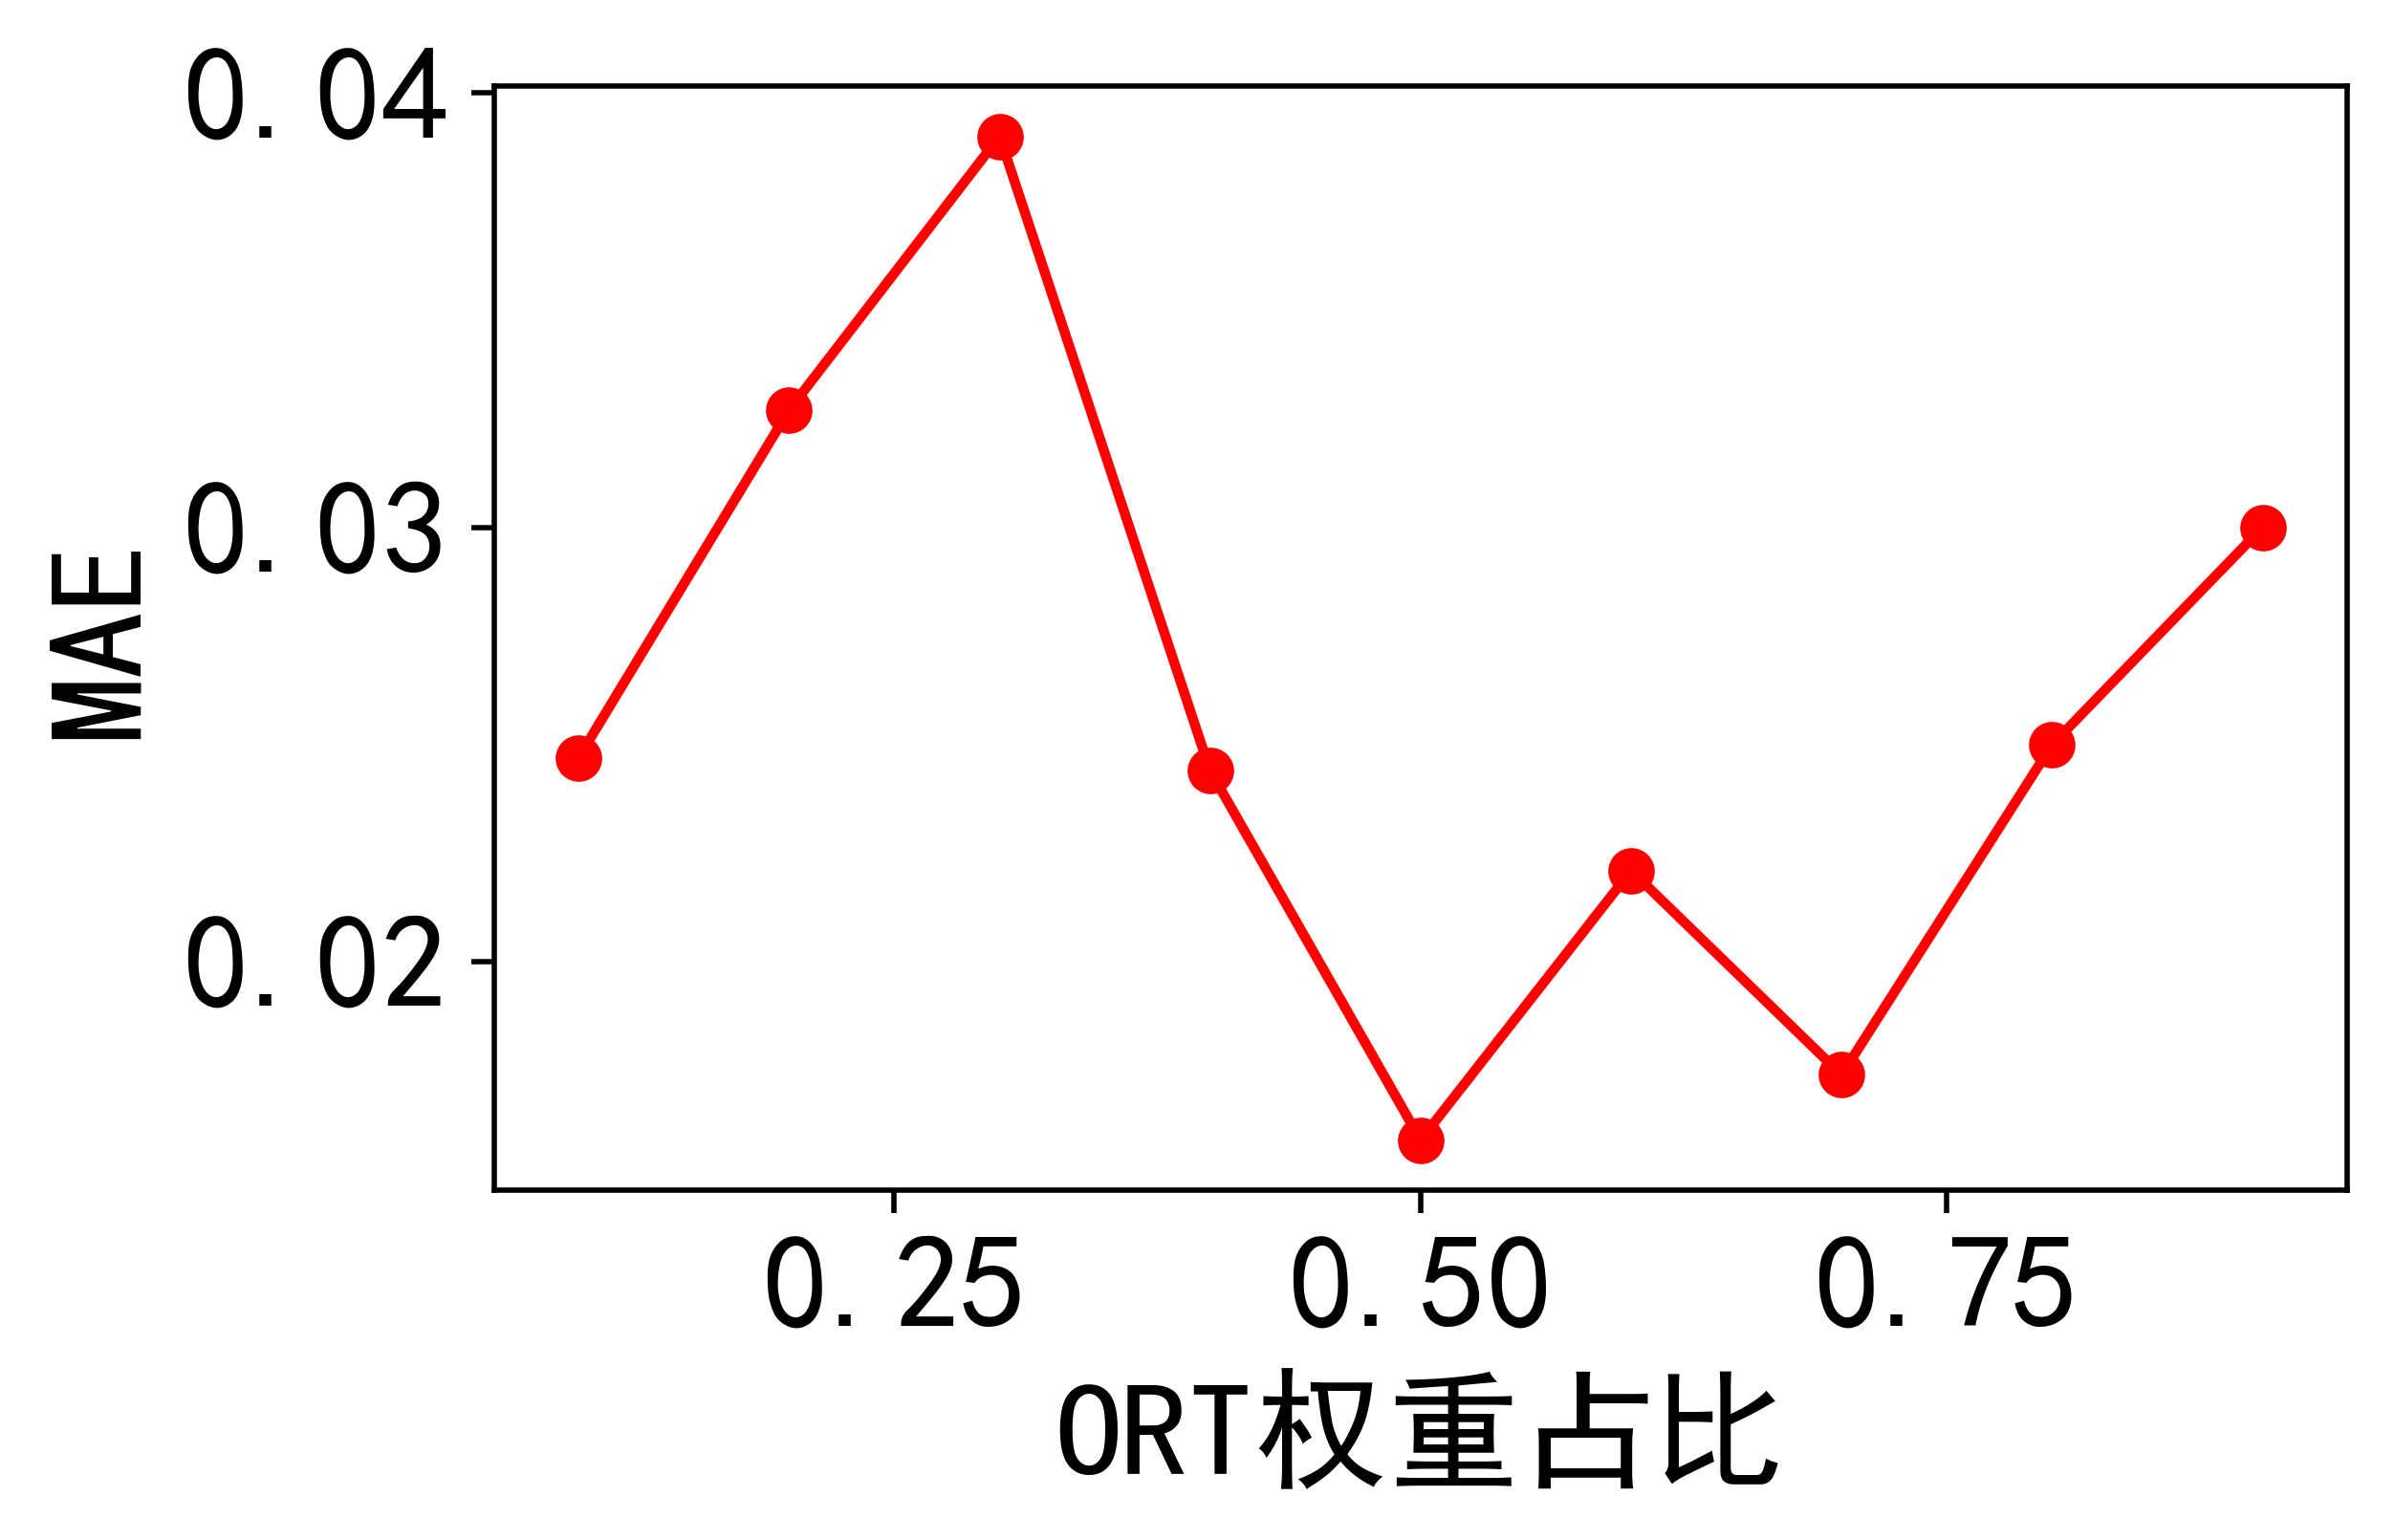

In [3]:
import matplotlib.pyplot as plt
import os 
import numpy as np
window_size = [10, 20, 30, 40, 50, 60]
window_mae = [0.0188, 0.0298, 0.0184, 0.0209, 0.0197, 0.0185]
ORT_weight = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MIT_weight = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
weight_error = [0.0247, 0.0327, 0.039, 0.0244, 0.0159, 0.0221, 0.0174, 0.025, 0.03]
rmse_error = [0.00009, 0.00011, 0.00016, 0.00014, 0.00005]
mae = [0.00082, 0.00084, 0.00085, 0.00089, 0.00094]
mae_error = [0.00006, 0.00008, 0.00014, 0.00009, 0.00009]
mape = [41.25450, 42.94209, 43.56011, 43.06638, 45.87822]
mape_error = [1.86221, 2.45860, 3.41902, 3.32948, 2.35026]
# plt.errorbar(x_label, rmse, color='r', yerr=rmse_error)
size = 20
plt.rcParams['font.family'] = 'SimHei'
plt.tick_params(labelsize=size)
plt.plot(window_size, window_mae, color='r', marker='o')
plt.xlabel('滑动窗口', fontsize=size)
plt.ylabel('MAE', fontsize=size)
plt.savefig(os.path.join('../../../Graduation thesis/Refpicture/', 'IMWindow'+'.jpg'), bbox_inches='tight', pad_inches=0.0, dpi=500)
plt.clf()
plt.tick_params(labelsize=size)
plt.plot(ORT_weight, weight_error, color='r', marker='o')
plt.xlabel('ORT权重占比', fontsize=size)
plt.ylabel('MAE', fontsize=size)
plt.savefig(os.path.join('../../../Graduation thesis/Refpicture/', 'ORTWeight'+'.jpg'), bbox_inches='tight', pad_inches=0.0, dpi=500)

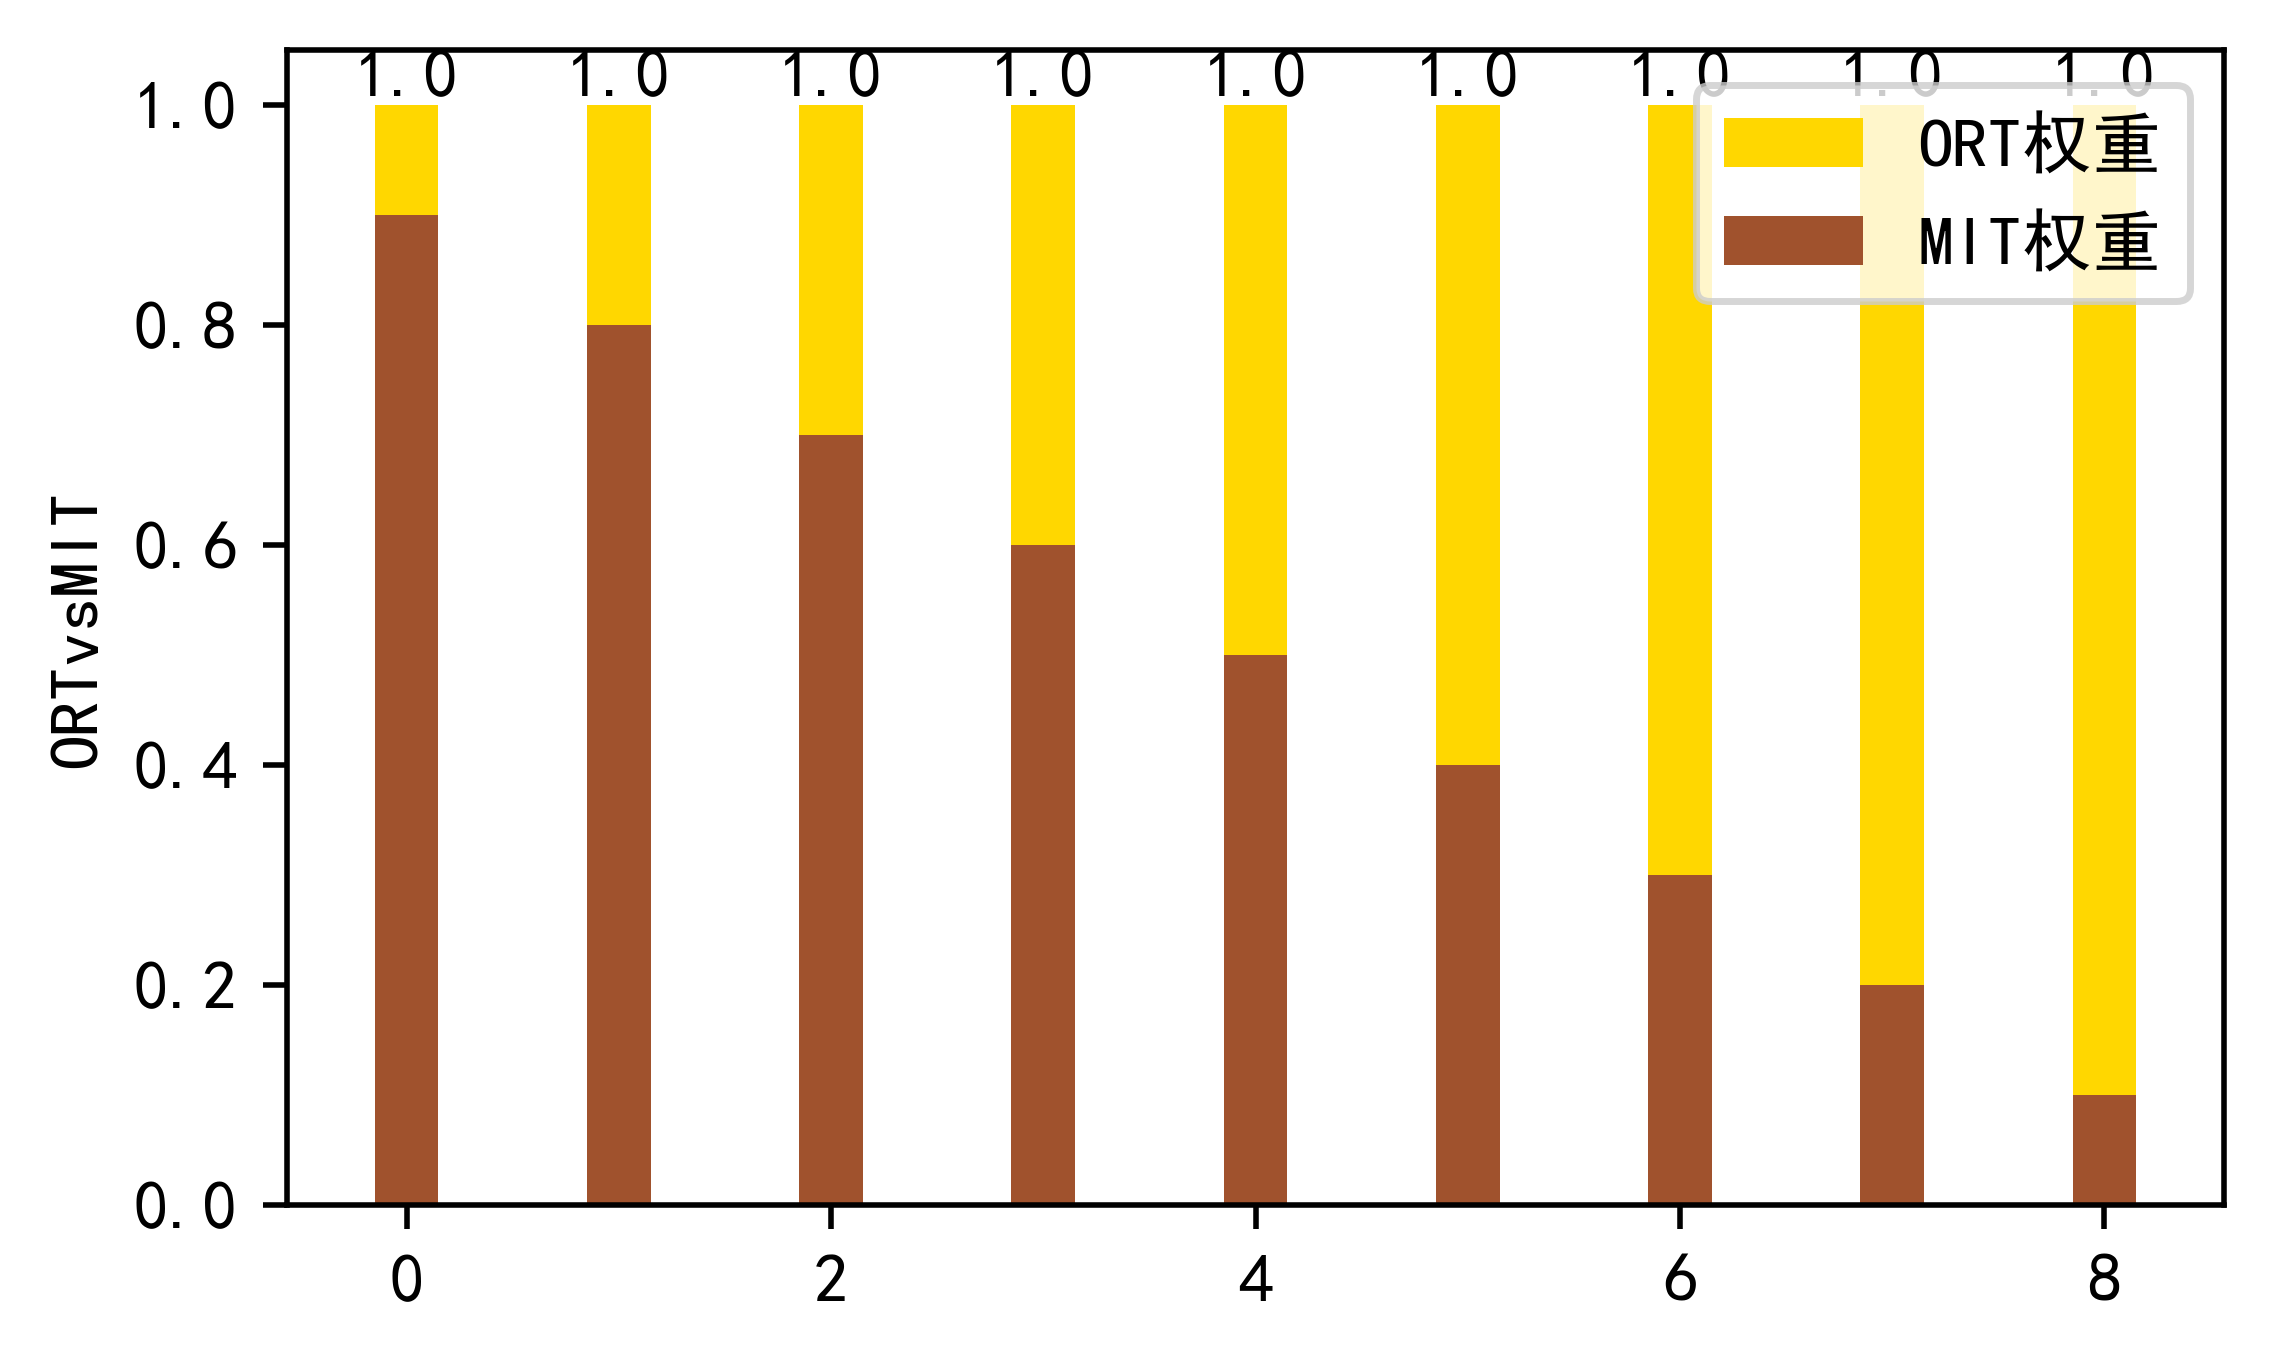

In [2]:
#库导入
from matplotlib import pyplot as plt
import numpy as np

#参数设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.figsize'] = (5,3)

#国家和奖牌数据输入、柱状图宽度设置
idx = [i for i in range(0, 9)]
ORT_weight = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MIT_weight = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
weight_error = [0.0247, 0.0327, 0.039, 0.0244, 0.0159, 0.0221, 0.0174, 0.025, 0.03]
gold_medal = np.array([16, 12, 9, 8, 8])
silver_medal = np.array([8, 10, 4, 10, 5])
bronze_medal = np.array([13, 5, 2, 7, 5])
width = 0.3
size = 20
#绘图
plt.bar(idx, ORT_weight, color='gold', label='ORT权重',
        bottom= MIT_weight,width=width)
plt.bar(idx, MIT_weight, color='#A0522D', label='MIT权重',width=width)

#设置y轴标签，图例和文本值
plt.ylabel('ORTvsMIT')
plt.legend(loc='upper right')
for i in range(len(idx)):
    max_y = ORT_weight[i]+MIT_weight[i]
    plt.text(idx[i], max_y, max_y, va="bottom", ha="center")


# Visualize dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("../../Datasets/FDatasets/phase_3/caisson3.csv", parse_dates=True, index_col = "collect_time")
# targets = pd.read_csv("../../Datasets/ODatasets/phase3/targets.csv", parse_dates=True, index_col = "collect_time")
# df = pd.merge(stress, targets, how='left', on='collect_time')
pd.set_option('display.max_columns', 14)
df.head(-8)


,GDY_2,GDY_3,GDY_4,GDY_5,GDY_6,GDY_7,GDY_8,...,DD,FI,TI,BFO,BTO,TFO,TTO
collect_time,,,,,,,,,,,,,,,
2024-02-22 14:20:00,-7.254422,58.715661,95.489077,20.207313,112.814067,82.643148,13.673157,...,0.000000,-0.000507,0.000489,0.153718,1.007660,0.136600,1.025414
2024-02-22 14:30:00,-7.254422,58.715661,95.513037,20.223525,112.773330,82.635149,13.681305,...,0.003950,-0.000452,0.000477,0.155369,1.010284,0.138689,1.026108
2024-02-22 14:40:00,-7.254422,58.723699,95.513037,20.207313,112.740741,82.635149,13.713894,...,0.010200,-0.000525,0.000465,0.155399,1.008652,0.139130,1.027016
2024-02-22 14:50:00,-7.254422,58.723699,95.513037,20.207313,112.781477,82.643148,13.697599,...,0.006319,-0.000615,0.000485,0.153932,1.006340,0.136956,1.027863
2024-02-22 15:00:00,-7.254422,58.731737,95.529010,20.223525,112.732594,82.643148,13.705747,...,0.002989,-0.000477,0.000542,0.156657,1.011742,0.137687,1.028442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-23 08:10:00,-9.229647,47.322966,75.027946,18.627519,91.480771,72.470364,12.557770,...,0.000954,-0.001008,0.002507,0.187013,0.210256,0.099264,0.245526
2024-03-23 08:20:00,-9.229107,47.324037,75.025508,18.632383,91.480228,72.471431,12.558314,...,0.001299,-0.001029,0.002470,0.185418,0.209613,0.098967,0.245635
2024-03-23 08:30:00,-9.227486,47.324573,75.023910,18.633464,91.480771,72.474097,12.562116,...,0.000547,-0.001025,0.002439,0.184257,0.209890,0.098880,0.245765
